# Predykcja cen wynajmu mieszkań.

Celem projektu jest stworznie narzędzia, które pozwoli przewidzieć cenę wynajmu mieszkania na podstawie infomacji zawartych w ogłoszeniu. Mam zamiar rowijać projekt używając kolejnych moetody machine learningu. Moim osobistym celem tworzenia projektu jest więc nauka i testowanie modeli w praktyce.

Spis treści:

1. [Pobranie danych z ogłoszeń wynajmu mieszkań ze strony OLX i stworzenie bazy danych.](#1.-Pobranie-danych-z-ogłoszeń-wynajmu-mieszkań-ze-strony-OLX-i-stworzenie-bazy-danych.)
2. [Wstępna obróbka i analiza danych.](#2.-Wstępna-obróbka-i-analiza-danych.)
3. [Predykcja cen za pomocą modelu regresji liniowej.](#3.-Predykcja-cen-za-pomocą-modelu-regresji-liniowej.)  
  3.1.[Założenia modelu.](#Założenia-modelu.)


## [1. Pobranie danych z ogłoszeń wynajmu mieszkań ze strony OLX i stworzenie bazy danych.](https://github.com/pawellachowski777/Apartments/blob/master/python/web_scrap.ipynb)

W myśl zasady DRY, importuję funkcję *adverts* z notebooka *web_scrap*.

In [1]:
import import_ipynb

In [2]:
from datetime import datetime
from web_scrap_function import adverts

In [3]:
now = datetime.now()
print(now.strftime('%d/%m/%Y %H:%M:%S'))

rows = adverts(pages=1)

04/02/2021 12:23:58
pobrano dane z 35 ogłoszeń.


OLX posiada ograniczenie 25 stron z ogłoszeniami. Podanie większej ilości sprawia, że scraper działa mniej ekektywnie. Pobiera bardzo dużo zduplikowanych danych, prawdopodobnie ogłoszeń premium. Zdarzało się też, że przy zbyt długim scrapowaniu, host blokował mi dostęp do strony. Dlatego też dane pobierałem "na raty". 25 stron jednego dnia, po 2 dniach kolejne 25 stron zapełniało się nowymi ogłoszeniami. Przez ten problem nie udało się jednak uniknąć powielania danych. Stwierdziłem jednak, że łatwiej i efektywniej będzie usunąć duplikaty w procesie obróbki niż walczyć z nimi na tym etapie.

## 2. Wstępna obróbka i analiza danych.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy import stats

In [5]:
path_data = r'E:\python\projects\apartments\data'
path_pickle = r'E:\python\projects\apartments\pickle'

In [6]:
df_waw = pd.read_excel(path_data + '\web_scrap.xlsx')
df_waw.head()

,link,miasto,dzielnica,cena,od,poziom,umeblowanie,zabudowa,powierzchnia,pokoje,czynsz dodatkowo
0,https://www.olx.pl/oferta/dwupokojowe-z-oddzie...,"Warszawa,",Targówek,2300,Biuro / Deweloper,2,1,Apartamentowiec,60,2,1
1,https://www.olx.pl/oferta/2-pokoje-bielany-met...,"Warszawa,",Bielany,3000,Osoby prywatnej,3,1,Apartamentowiec,56,2,1
2,https://www.olx.pl/oferta/kawalerka-browary-wa...,"Warszawa,",Śródmieście,2200,Osoby prywatnej,2,1,Apartamentowiec,29,Kawalerka,1
3,https://www.olx.pl/oferta/dwupokojowa-kawalerk...,"Warszawa,",Mokotów,1800,Osoby prywatnej,2,1,Blok,20,2,350
4,https://www.olx.pl/oferta/wynajme-mieszkanie-f...,"Warszawa,",Wawer,2300,Osoby prywatnej,2,1,Apartamentowiec,60,3,500


Czyszczenie danych wykonałem w odzielnym notebooku (link powyżej)

In [9]:
df_waw = pd.read_pickle(path_pickle + '\df_waw_analyse.pickle')
df_waw.head()

,dzielnica,od,poziom,umeblowanie,zabudowa,powierzchnia,pokoje,cena całkowita,cena za pokoj
0,Targówek,Biuro / Deweloper,2,1,Apartamentowiec,60,2,2301,1150.500000
1,Bielany,Osoby prywatnej,3,1,Apartamentowiec,56,2,3001,1500.500000
2,Śródmieście,Osoby prywatnej,2,1,Apartamentowiec,29,1,2201,2201.000000
3,Mokotów,Osoby prywatnej,2,1,Blok,20,2,2150,1075.000000
4,Wawer,Osoby prywatnej,2,1,Apartamentowiec,60,3,2800,933.333333


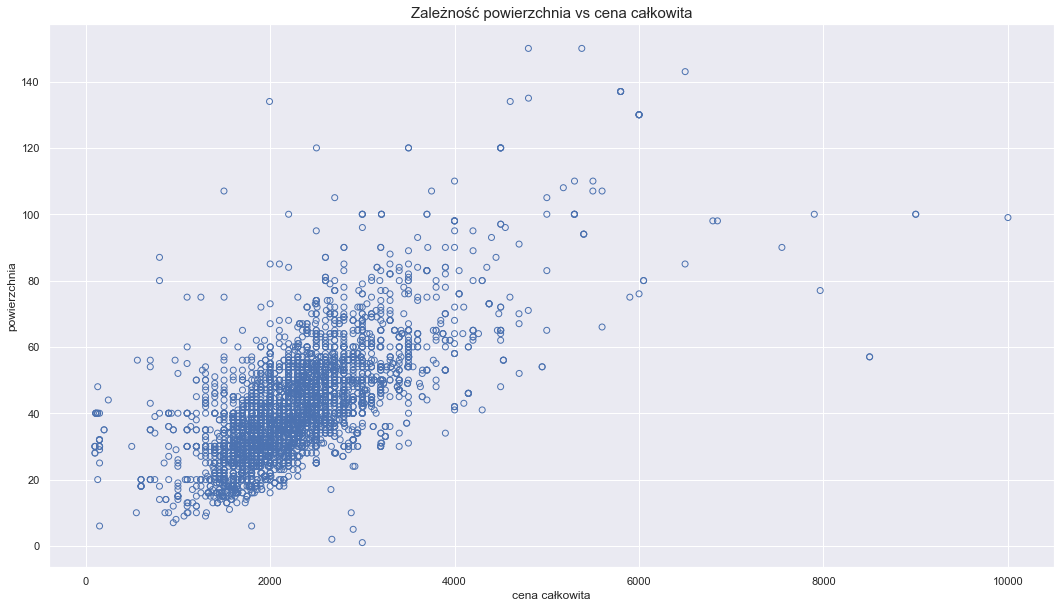

In [11]:
plt.figure(figsize=(18,10))
plt.xlabel('cena całkowita')
plt.ylabel('powierzchnia')
plt.scatter(df_waw['cena całkowita'], df_waw['powierzchnia'], facecolors='none', edgecolors='b')
plt.title('Zależność powierzchnia vs cena całkowita', fontdict={'fontsize':15})
plt.show()

Wciąż widać, że baza nie jest doskonała. Istnieje kilka ogłoszeń, gdzie cena nie przekracza 100 zł lub powierzchnia jest bliska 0. Nie będę jednak ręcznie usuwał tych niedoskonałości. Podczas analizy wyników należy po prostu uwzględnić fakt, że ogłoszenia tworzone są przez ludzi i mogą być obarczone błędem.

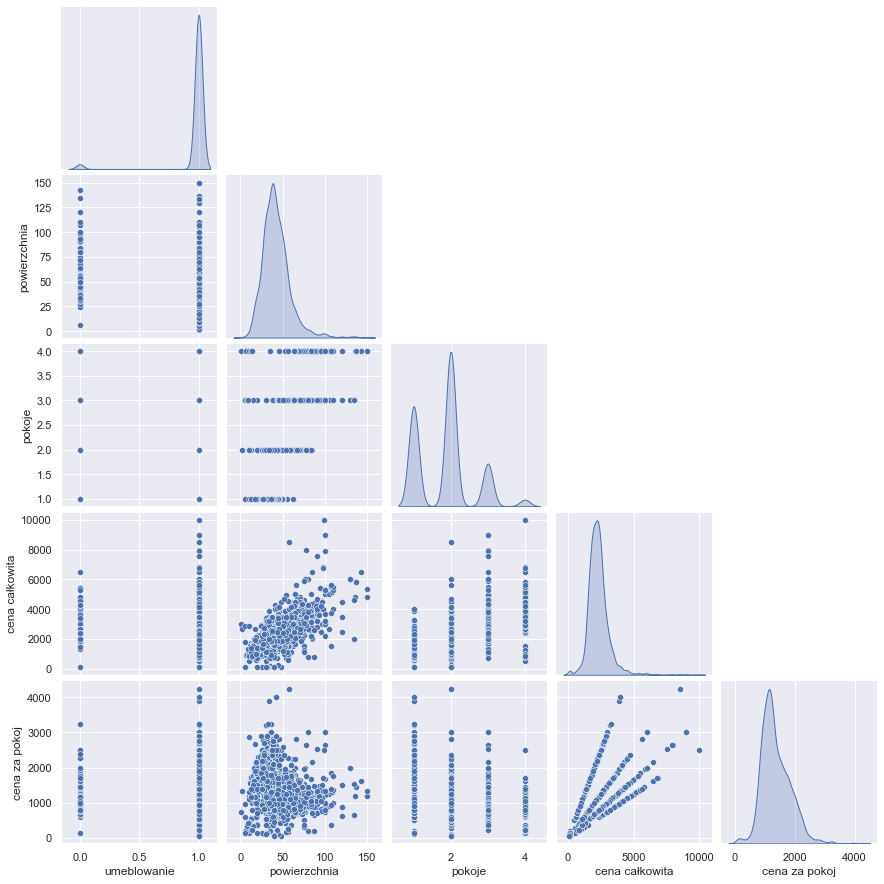

In [22]:
sns.pairplot(df_waw, corner=True, diag_kind='kde')
plt.show()

Wnioski ze wstępnej analizy:  
1. występuje silnia, dodatnia korelacja występuje między ceną całkowitą a powierzchnią,
2. zdecydowana większość mieszkań jest umeblowana,
3. rozkład ceny całkowitej jest silnie skoncentrowany wokół średniej (wysoka kurotza),
4. ciekawie wygląda zależność między powierzchnią a ceną za pokój.

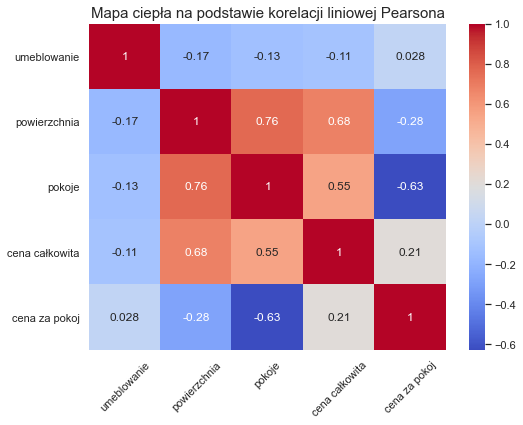

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(df_waw.corr(), cmap='coolwarm', annot=True)
plt.xticks(rotation=45)
plt.title('Mapa ciepła na podstawie korelacji liniowej Pearsona', fontdict={'fontsize':15})
plt.show()

1. Potwierdza się wniosek ze wstępnej analizy, o silnej dodatniej korelacji między ceną całkowitą a powierzchnią.
2. Najsilniej skorelowane są kolumny powierzchnia i liczba pokoi, co wydaje się być dość oczywiste. Należy jednak pamiętać o tym przy tworzeniu modelu, ponieważ zmienne odbaśniające nie mogą być ze sobą skorelowane.
3. Większa liczba pokoi oznacza spadek współczynika cena za pokój. (silna korelacja ujemna). Podobna zależność zachodzi między kolumnami powierzchnia i cena za pokój, jednak korelacja jest słabsza. Im mniejsze mieszkanie, tym więcej płacimy za metr kwadratowy.

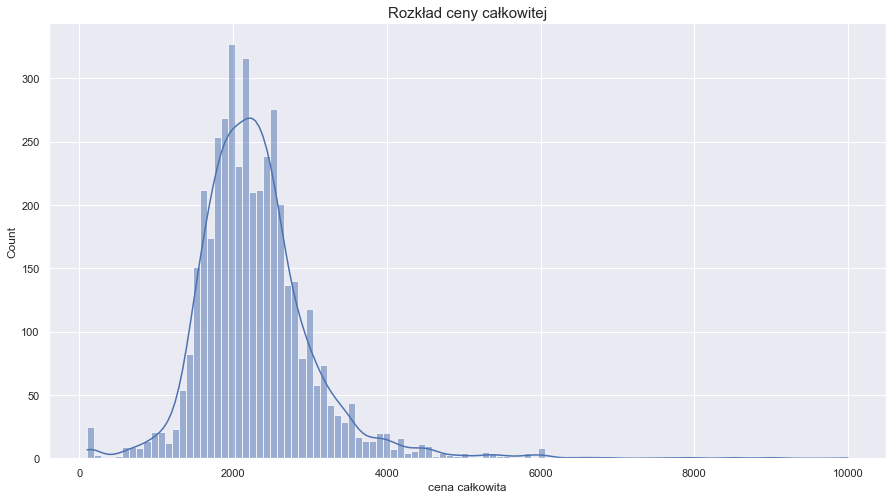

In [26]:
plt.figure(figsize = (15,8))
sns.histplot(df_waw['cena całkowita'], kde=True)
plt.title('Rozkład ceny całkowitej', fontdict={'fontsize':15})
plt.show()

In [27]:
print('''Badanie normalności rozkładu 
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 5%
''')

stat, p = stats.shapiro(df_waw['cena całkowita'])
print(f'p_value: {p:.5f} \n')

if p > 0.05:
    print('Nie ma podstaw do odrzucenia hipotezy zerowej. Występuje rozkład normalny.')
else:
    print('Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.')

Badanie normalności rozkładu 
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 5%

p_value: 0.00000 

Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.


In [28]:
skosnosc = stats.skew(df_waw['cena całkowita'])
kurtoza = stats.kurtosis(df_waw['cena całkowita'])
print(f'Skośność: {skosnosc:.3f} \nKurtoza: {kurtoza:.3f}')

Skośność: 2.001 
Kurtoza: 11.716


Bardzo wysokie skoncentrowanie wartości wokół średniej zaburza normalność rozkładu. Rozkład jest także prawoskośny, więcej niż 50 % jednostek ma wartości mniejsze niż średnia.

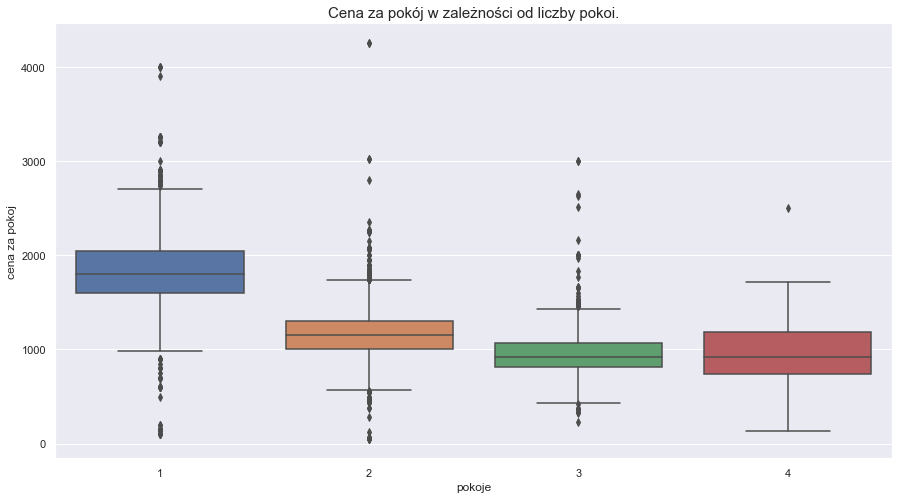

In [29]:
plt.figure(figsize = (15,8))
sns.boxplot(x='pokoje', y='cena za pokoj', data=df_waw)
plt.title('Cena za pokój w zależności od liczby pokoi.', fontdict={'fontsize':15})
plt.show()

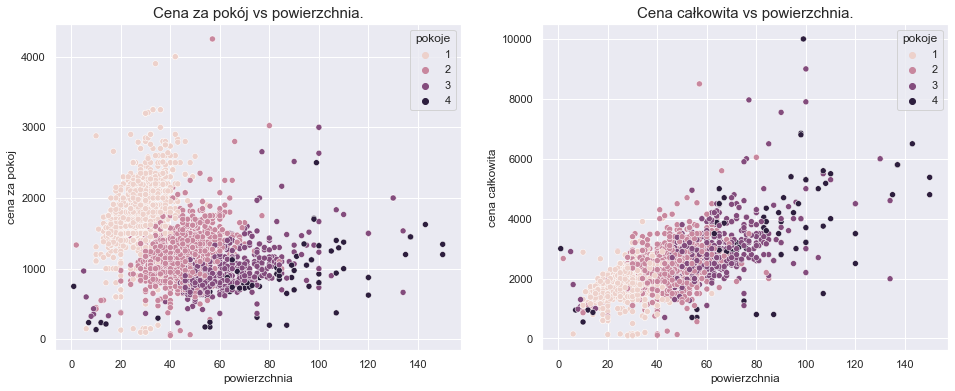

In [49]:
plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)

sns.scatterplot(x=df_waw['powierzchnia'], y = df_waw['cena za pokoj'], hue=df_waw['pokoje'])
plt.title('Cena za pokój vs powierzchnia.', fontdict={'fontsize':15})

plt.subplot(1,2,2)
sns.scatterplot(x=df_waw['powierzchnia'], y = df_waw['cena całkowita'], hue=df_waw['pokoje'])
plt.title('Cena całkowita vs powierzchnia.', fontdict={'fontsize':15})
plt.show()

Wygląda na to, że liczba pokoi jest bardzo dobrze zdefiniowana powierzchnię. Dlatego ta informacja w modelu jest zbędna.

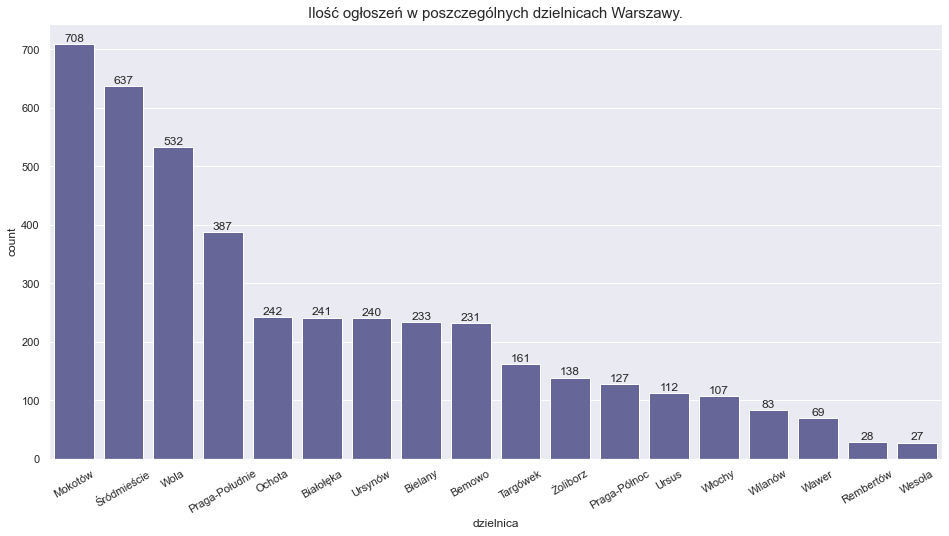

In [48]:
counts = df_waw['dzielnica'].value_counts()

plt.figure(figsize = (16,8))
plt.xticks(rotation=30)
sns.countplot(x = df_waw['dzielnica'], color='blue', saturation=0.2, order=counts.index)
plt.title('Ilość ogłoszeń w poszczególnych dzielnicach Warszawy.', fontdict={'fontsize':15})
for i in range(len(counts)):
    plt.text(i, counts[i]+5, counts[i], ha='center')
plt.show()

Najwięcej ogłoszeń w Warszawie dotyczy dzielnic: Śródmieście, Mokotów, Wola. Dzielnice te można nazwać biznesową częścią miasta. Natomiast w dzielicach z obrzeży Warszawy (Włochy, Wawer, Rembertów, Wesoła), mieszkań do wynajęcia jest o wiele mniej. Tak mała ilość ogłoszeń dla tych dwóch ostatnich może być problemem dla regresji.

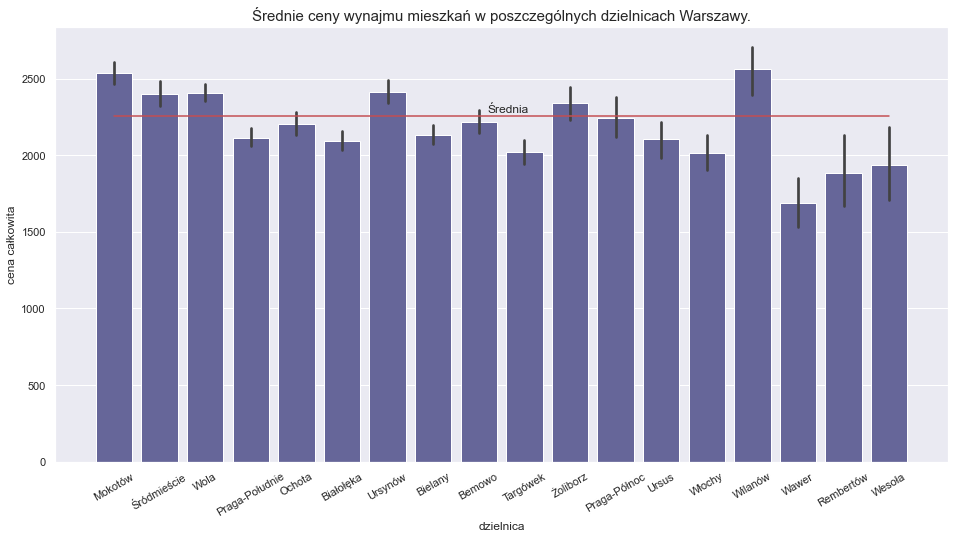

In [54]:
plt.figure(figsize = (16,8))
plt.xticks(rotation=30)
sns.barplot(y='cena całkowita', x='dzielnica', data=df_waw, color='blue', saturation=0.2, order=counts.index)
plt.title('Średnie ceny wynajmu mieszkań w poszczególnych dzielnicach Warszawy.', fontdict={'fontsize':15})
plt.plot([2257,2257]*9, color = 'r') # średnia cena
plt.text(8.2,2280,'Średnia')
plt.show()

Dla dzielnic biznesowych, średnie ceny wynajmu kształtują się powyżej średniej ze wszystkich ogłoszeń. Najdroższe mieszkania znajdują się na Wilanowie. Wysoką średnią mają także Żoliborz i Ursynów. Wawer, Rembertów i Wesoła mają ceny dużo poniżej średniej ogólnej.  
Przedziały ufności w 5 ostatnich dzielnicach wydają się być za duże. Oznacza to, że ich wartości mogą znacznie odbiegać od średniej. Przy tworzeniu regresji będę miał to na uwadze. Jeśli okaże się to problemem, pobiorę więcej danych dla tych dzielnic.

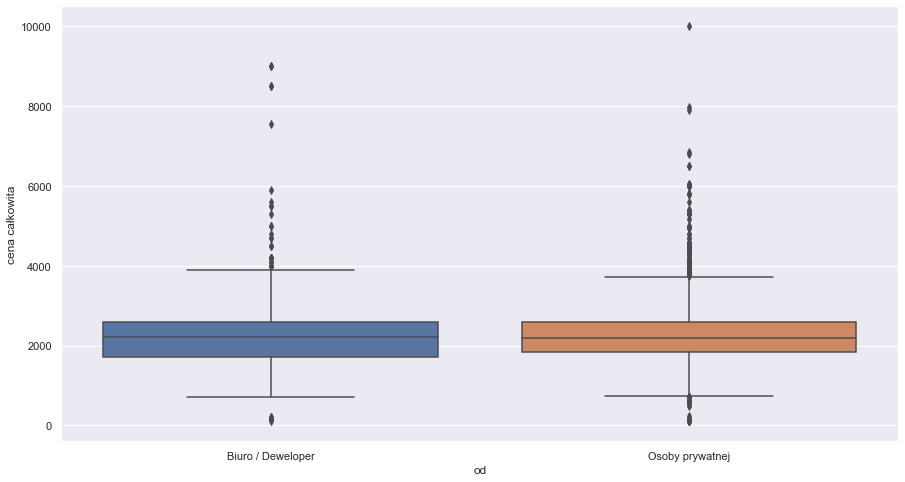

In [55]:
plt.figure(figsize = (15,8))
sns.boxplot(x='od', y='cena całkowita', data=df_waw)
plt.title('', fontdict={'fontsize':15})
plt.show()

Informacja, kto wstawia ogłoszenie, nie wpływa znacząco na cenę mieszkania. Zauważyć można, że ogłoszenia od Deweloperów mają mniej wartości skrajnych. 

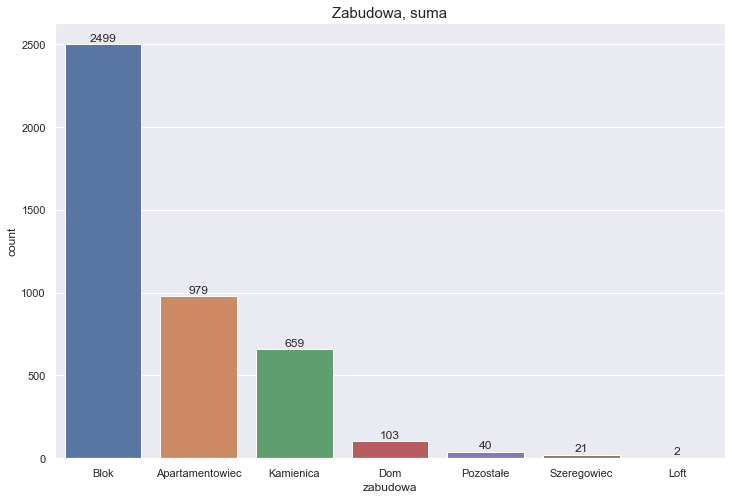

In [30]:
counts = df_waw['zabudowa'].value_counts()

plt.figure(figsize = (12,8))
plt.title('Zabudowa, suma', fontdict={'fontsize':15})
for i in range(len(counts)):
    plt.text(i, counts[i]+20, counts[i], ha='center')
sns.countplot(x=df_waw['zabudowa'], order=counts.index)
plt.show()

Wyrzucę wszystkie ogłoszenia o wartości "Loft" (za mało danych) i "Pozostałe" (wprowadza niejednoznaczność).

In [31]:
drop_value(df_waw, 'zabudowa', 'Loft')
drop_value(df_waw, 'zabudowa', 'Pozostałe')

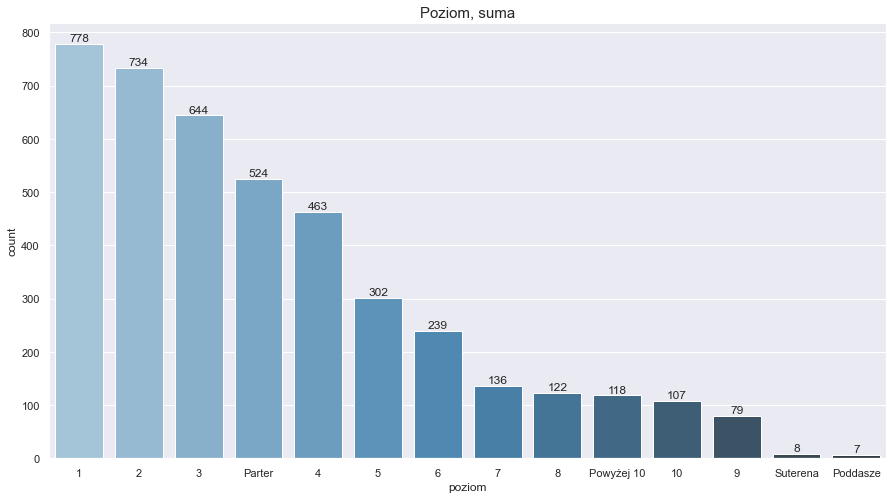

In [32]:
counts = df_waw['poziom'].value_counts()
plt.figure(figsize=(15,8))
for i in range(len(counts)):
    plt.text(i, counts[i]+5, counts[i], ha='center')
plt.title('Poziom, suma', fontdict={'fontsize':15})
sns.countplot(x=df_waw['poziom'], order=counts.index, palette = 'Blues_d')
plt.show()

Wartości "Poddasze" i "Suterena" także powinny być usunięte. Kończąc analizę, usuwam także kolumnę "cena za pokój" i "pokoje".

In [33]:
drop_value(df_waw, 'poziom', 'Suterena')
drop_value(df_waw, 'poziom', 'Poddasze')
df_waw.drop(['cena za pokoj', 'pokoje'], axis = 1, inplace = True)

## 3. Predykcja cen za pomocą modelu regresji liniowej.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

Najpierw trzeba pozbyć się wsystkich tekstowych wartości z bazy, aby model regresji mógł je uwzględnić.

In [35]:
df_waw

,dzielnica,od,poziom,umeblowanie,zabudowa,powierzchnia,cena całkowita
0,Targówek,Biuro / Deweloper,2,1,Apartamentowiec,60,2301
1,Bielany,Osoby prywatnej,3,1,Apartamentowiec,56,3001
2,Śródmieście,Osoby prywatnej,2,1,Apartamentowiec,29,2201
3,Mokotów,Osoby prywatnej,2,1,Blok,20,2150
4,Wawer,Osoby prywatnej,2,1,Apartamentowiec,60,2800
...,...,...,...,...,...,...,...
4241,Wola,Biuro / Deweloper,5,1,Apartamentowiec,28,2351
4242,Żoliborz,Osoby prywatnej,Parter,0,Kamienica,50,2400
4243,Praga-Południe,Biuro / Deweloper,5,1,Blok,27,1700
4244,Żoliborz,Biuro / Deweloper,2,0,Blok,34,2001


W kolumnach: "dzielnica", "od", "poziom", "zabudowa", trzeba utworzyć kolumny dummies. Dodatkowo muszę wyrzucić którąś z nowo utworzonych kolumn. W przeciwnym przypadku, model nie będzie w stanie zinterpretować czy zmiana jest spowodowana wartośćią 1 w tej kolumnie czy 0 w pozostałych.   
Przykład: _Apartamentowiec = 1 - Blok - Dom - Kamienica - Szeregowiec_. Kolumna Apartamentowiec jest idealnie zdefiniowana przez pozostałe 4 kolumny. Prowadzi to do wielu problemów w regresji (nieinterpretowalność coeff, współliniowość zmiennych).  
W kolumnach dummies odrzucam: Mokotów dla "dzielnicy", osoby przywatnej dla "od", powyżej 10 dla "poziom", apartamentowiec dla "zabudowa".

In [36]:
dzielnica = pd.get_dummies(data=df_waw['dzielnica'])
od = pd.get_dummies(data=df_waw['od'])
poziom = pd.get_dummies(data=df_waw['poziom'])
zabudowa = pd.get_dummies(data=df_waw['zabudowa'])

df_waw = pd.concat([df_waw, dzielnica, od, poziom, zabudowa], axis=1)

y = df_waw['cena całkowita']
X = df_waw.drop(['cena całkowita', 'dzielnica', 'od', 'poziom', 'zabudowa',
                 'Mokotów', 'Osoby prywatnej', 'Powyżej 10', 'Apartamentowiec'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

Stworzenie modelu regresji liniowej.

In [37]:
X_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_const)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         cena całkowita   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     99.68
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:55:58   Log-Likelihood:                -21732.
No. Observations:                2844   AIC:                         4.354e+04
Df Residuals:                    2808   BIC:                         4.375e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1534.7481     91.29

OLS Regression Results jest w tym przypadku tabelą poglądową. Została stworzona na podstawie danych treningowych i walidacja przebiega na tych samych danych. W moim modelu trening był przepowadzany na danych trningowych, a test na testowych. Dlatego mogą pojawiać się nieznaczne różnice w statystykach w tabeli OLS i wyliczonych na podstawie mojego modelu. Jednak tabela zawiera dużo przydatnych informacji w jednym miejscu. Wnioski wyciągnięte po jej analizie będą zastosowane w modelu.  

Iterpretacja wyniku regresji:
1. Statystyka R kwadrat jest dość wysoka ok. 55 %. Model w 55 % wyjaśnia cenę wynajmu mieszkania.
2. Uśrednione R kwadrat, uwzględniające ilość stopni swobody, nie odbiega od R kwadrat. Oznacza to, że ilość zmiennych nie wpływa negatywnie na ogólny wynik.
3. F-stat jest wysokie, a p_value jest bliskie 0. Oznacza to, że mnożnik (coefficeint) zmiennych objaśniających jest różny od zera. Innymi słowy, prawdopodobieństwo, że cena wynajmu jest losowa jest bliskie 0. 
4. Mnożnik wskazuje, o ile złotych podniesie się cena wynajmu jeśli wartość zmiennej zwiększy się o 1, a pozostałe zmienne będą stałe. W przypadku zmiennych dummies interpretować go trzeba w odniesieniu do kolumny odrzuconej w danym zakresie. Przy interpretacji coef, należy patrzeć także na pozostałe parametry wskazujące na jego wiadrygodniość.
  1. Umeblowanie: bardzo wysokie P>|t| (p_value). Istnieje 85% szansy, że wartość coef jest losowa. Pozbędę się tej zmiennej.
  2. Dla zmiennych utworzonych od "dzielnica" coef wskazuje o ile zmieni się cena mieszkania w tej dzielnicy, w porównaniu do Mokotowa. Mieszkanie na Bemowie będzie średnio o 135,61 zł tańsze niż na Mokotowie. Problem pojawia się, gdy ceny mieszkań w dzielnicy są zbliżone np. Śródmieśćie. Istnieje wtedy duża szansa (około 60%), że wskaźnik coef będzie się różnił od tego który mamy podany w tabeli. Jednak jak spojrzy się na przedziały ufności, Widać że nie są one szerokie. Od -43 zł do 25 zł. Widzimy więc, że ceny w tych dzielnicach są zbliżone, więc Wysokie p_value może być zignorowane.
  3. Mieszkania usytuowane powyżej 10 piętra są z regóły droższe, podobnie jak apartamentowce.

In [38]:
X = X.drop('umeblowanie', axis=1) # usuwam umeblowanie

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

# tworzę model regresji

lm = LinearRegression()
lm.fit(X_train, y_train)
prediction = lm.predict(X_test) 
residuals = prediction - y_test# składniki resztowe

X_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_const)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         cena całkowita   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     102.6
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:55:59   Log-Likelihood:                -21732.
No. Observations:                2844   AIC:                         4.353e+04
Df Residuals:                    2809   BIC:                         4.374e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1523.8485     69.39

Po usunięciu umeblowawnia, uśrednione R^2 nieznacznie poprawiło się. Oznacza to, że model bez tej zmiennej jest lepszy. Poprawiły się także wartości p_value dla pozostałych zmiennych.

### Założenia modelu.

Gdy model regresji spełania jego podstawowe założenia, można uznać, że jest on wiarygodny. Naruszanie założeń może sprawić, że dane nie będą trafnie odzwierciedlały rzeczywistości. Już na etapie analizy danych wykonywałem czynności, które pomogą w spełnianiu założeń.

#### 1 Liniowość

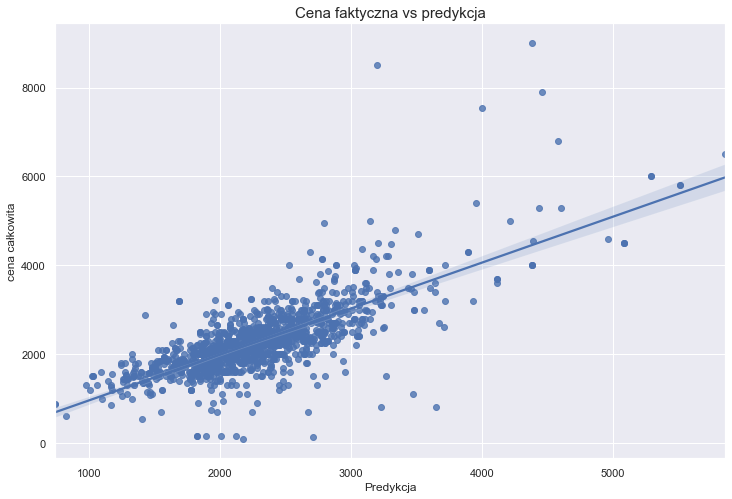

In [39]:
plt.figure(figsize = (12,8))
plt.xlabel('Predykcja')
plt.ylabel('Cena faktyczna')
plt.title('Cena faktyczna vs predykcja', fontdict={'fontsize':15})
sns.regplot(x=prediction, y=y_test)
plt.show()

In [40]:
results.f_pvalue # p_value dla F-statistic

0.0

Rozkład składników resztowych wskazuje na liniową zależność między ceną, a pozostałymi zmiennymi. Pojawiają się jednak wartości skrajne pod i nad linią regresji. Założenie liniowości można potwierdzić patrząc na wartość F-statistic i Prob(F-statistic) w tabeli OLS.

#### 2 Homoskedastyczność składników resztowych (stałość wariancji)

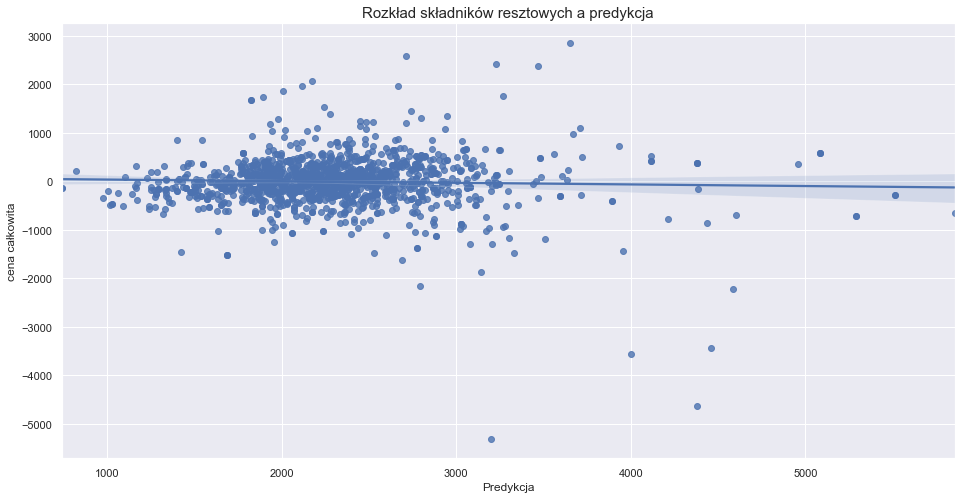

In [41]:
plt.figure(figsize=(16,8))
plt.xlabel('Predykcja')
plt.ylabel('Reszty')
plt.title('Rozkład składników resztowych a predykcja', fontdict={'fontsize':15})
sns.regplot(x=prediction, y=residuals )
plt.show()

Większość obserwacji mieści się w granicy błędu od -1000 do 1000. Wartości skrajne zaburzają homoskedastyczność rozkładu. 

In [42]:
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print(f'F-statistic: {test[0]:.4f}, p-value: {test[1]:.4f}')
if test[1] < 0.05:
    print('Nie występuje homoskedastyczność')
else:
    print('Występuje homoskedastyczność')

F-statistic: 1.0327, p-value: 0.2745
Występuje homoskedastyczność


#### 3 Normalność rozkładu składników resztowych

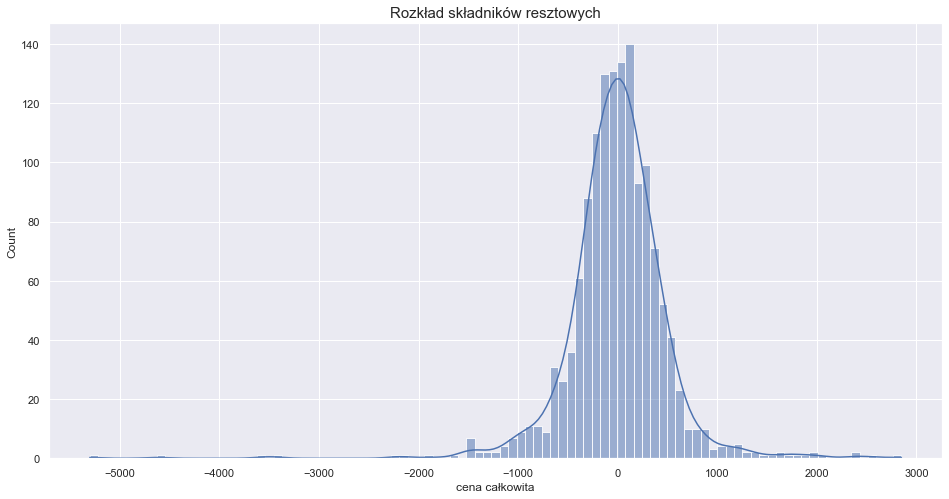

In [43]:
plt.figure(figsize=(16,8))
plt.title('Rozkład składników resztowych', fontdict={'fontsize':15})
sns.histplot(residuals, kde=True)
plt.show()

In [44]:
print('''Badanie normalności składników resztowych
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 0.05
''')

stat, p = stats.normaltest(residuals)
print(f'p_value: {p:.5f}')

if p > 0.05:
    print('Nie ma podstaw do odrzucenia hipotezy zerowej. Występuje rozkład normalny.')
else:
    print('Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.')

Badanie normalności składników resztowych
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 0.05

p_value: 0.00000
Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.


Składniki resztowe nie mają rozkładu normalnego. Te założenie regresji jest naruszone. Dane mają zbyt dużą kurtozę i za dużo wartości skrajnych. Trzeba więc założyć, że przedziały ufności i odchylenia standardowe nie są godne zaufania.

#### 4 Brak współliniowości zmiennych objaśniających

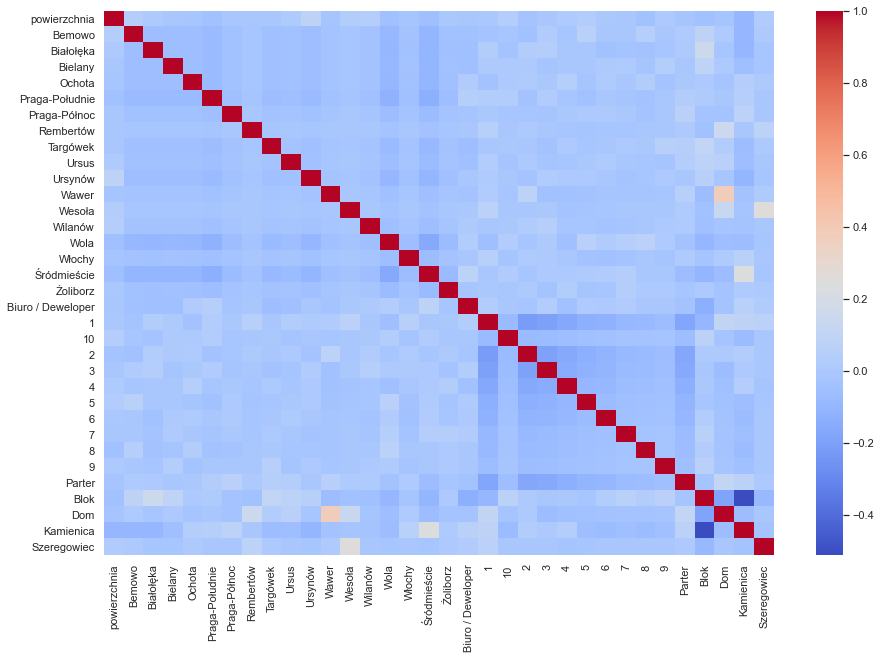

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(), cmap='coolwarm')
plt.show()

Założenie to wskazuje, że zmienne objaśniające nie mogą być ze sobą skorelowane. Wcześniejsze usuięcie kolumny "pokoje", oraz usunięcie po jednej kolumny ze zmiennych dummies, pozwalają spełnić te założnie. Na mapie ciepła, widać że niektóre zmienne są skorelowane, ale mają one raczej marginalne znaczenie np. Dom i Wawer. Wskazują one bardziej na charakter miejsca, a nie objaśniają wpływu na cenę.

In [46]:
# # wszystkie modyfikacje 

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

# from scipy import stats
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split

# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import statsmodels.stats.api as sms

# df_waw = pd.read_excel('web_scrap.xlsx')

# def drop_value(df, column, value): # funkcja do usuwania wybranych wartości
#     index = df[df[column] == value].index
#     df.drop(index=index, inplace=True)
#     df.reset_index(drop=True, inplace=True)

# index = df_waw[df_waw['pokoje'] == 'Kawalerka'].index
# for i in index:
#     df_waw.loc[i, 'pokoje'] = 1   
# df_waw['pokoje'] = df_waw['pokoje'].astype(int)

# drop_value(df_waw, 'poziom', 'Tak')
# drop_value(df_waw, 'poziom', 'Nie')

# df_waw.drop_duplicates(inplace=True)
# df_waw.drop(['link', 'miasto'], axis=1, inplace=True)

# df_waw['cena całkowita'] = df_waw['cena'] + df_waw['czynsz dodatkowo']
# df_waw.drop('cena', axis=1, inplace=True)
# df_waw.drop('czynsz dodatkowo', axis=1, inplace=True)
# df_waw.reset_index(drop=True, inplace=True)

# drop_value(df_waw, 'cena całkowita', df_waw['cena całkowita'].max())
# drop_value(df_waw, 'powierzchnia', df_waw['powierzchnia'].max())

# drop_value(df_waw, 'zabudowa', 'Loft')
# drop_value(df_waw, 'zabudowa', 'Pozostałe')

# drop_value(df_waw, 'poziom', 'Suterena')
# drop_value(df_waw, 'poziom', 'Poddasze')

# dzielnica = pd.get_dummies(data=df_waw['dzielnica'])
# od = pd.get_dummies(data=df_waw['od'])
# poziom = pd.get_dummies(data=df_waw['poziom'])
# zabudowa = pd.get_dummies(data=df_waw['zabudowa'])

# df_waw = pd.concat([df_waw, dzielnica, od, poziom, zabudowa], axis=1)

# y = df_waw['cena całkowita']
# X = df_waw.drop(['cena całkowita', 'dzielnica', 'od', 'poziom', 'zabudowa', 'umeblowanie', 'pokoje',
#                  'Mokotów', 'Osoby prywatnej', 'Powyżej 10', 'Apartamentowiec'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

In [47]:
lm = LinearRegression()
lm.fit(X_train, y_train)
prediction = lm.predict(X_test) 
residuals = prediction - y_test # składniki resztowe

In [51]:
import pickle 
with open(path_pickle + '\linear_model.pickle', 'wb') as writer:
    pickle.dump(lm, writer)

In [49]:
def price_predict(surfance, district, by='Osoby prywatnej', level='1', building='Blok'):
    """
    district: 'Bemowo', 'Białołęka', 'Bielany', 'Ochota', 'Praga-Południe', 'Praga-Północ', 
              'Rembertów', 'Targówek', 'Ursus', 'Ursynów', 'Wawer', 'Wesoła', 'Wilanów', 'Wola', 
              'Włochy', 'Śródmieście', 'Żoliborz', 'Mokotów',
    by: 'Biuro / Deweloper', 'Osoby prywatnej',
    level: '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'Parter', 'Powyżej 10',
    building: 'Blok', 'Kamienica', 'Dom', 'Szeregowiec', 'Apartamentowiec',
    
    To make this function work put the 'linear_model.pickle' file in the folder where you actually are.
    """
    
    import numpy as np
    import pickle 
    
    lm = pickle.load(open('linear_model.pickle', 'rb'))
    columns = ['powierzchnia', 'Bemowo', 'Białołęka', 'Bielany', 'Ochota',
               'Praga-Południe', 'Praga-Północ', 'Rembertów', 'Targówek', 'Ursus',
               'Ursynów', 'Wawer', 'Wesoła', 'Wilanów', 'Wola', 'Włochy',
               'Śródmieście', 'Żoliborz', 'Biuro / Deweloper', '1', '10', '2', '3',
               '4', '5', '6', '7', '8', '9', 'Parter', 'Blok', 'Dom', 'Kamienica',
               'Szeregowiec']
    list_district = columns[1:18] # brak Mokotów
    list_level = columns[19:30] # brak powyżej 10
    list_building = columns[30:] # brak apartamentowiec
    values = np.array(surfance)
    
    for dist in list_district:
        if dist == district:
            values = np.append(values, 1)
        else:
            values = np.append(values, 0)

    if by == 'Biuro / Deweloper':
        values = np.append(values, 1)
    else:
        values = np.append(values, 0)

    for lv in list_level:
        if lv == level:
            values = np.append(values, 1)
        else:
            values = np.append(values, 0)
            
    for build in list_building:
        if build == building:
            values = np.append(values, 1)
        else:
            values = np.append(values, 0)
    
    values = values.reshape(1,-1)
    predict = lm.predict(values)
    print(f'Przewidywana cena to {round(predict[0],2)} zł.')
    return predict

In [50]:
val = price_predict(surfance=20, district='Bielany', by='Osoby prywatnej', level='1', building='Blok')

Przewidywana cena to 1338.03 zł.
